## HW04 DCGAN (PyTorch)

MNIST 데이터셋을 이용해 conditional generative adversarial networks (Conditional GAN) 기반 generative model을 구축한다.

1. 조건(condition)은 데이터의 label로 부여한다.
2. noise z에 대한 확률분포 p(z)가 다차원 normal distribution을 따른다고 가정한다.
3. 딥네트워크는 두 가지 구조로 설계해 본다.
  - 생성 네트워크(G)와 판별 네트워크(D)를 모두 fully-connected layer로 구성한다.
  - 생성 네트워크(G)와 판별 네트워크(D)를 모두 convolutional layer로 구현할 경우, 반드시 fully-connected layer 결과와 비교 분석하도록 한다.

다음을 확인하는 리포트를 Colab 노트북을 이용하여 작성한다.

1. 조건(condition)을 Conditional GAN의 생성 네트워크(G)와 판별 네트워크(D)에 어떻게 텐서 형태를 취해 입력으로 주어야 하는지 명시하고, 이에 대해 논의한다.
2. 학습이 진행되며 네트워크가 고정된 noise 값으로부터 만들어내는 데이터의 모습이 어떻게 달라지는지 확인한다.
3. 매 epoch마다의 loss값을 저장하여 학습이 끝난 뒤 그래프로 나타낸다.
4. noise의 차원을 임의로 바꾸어 보고, 이때 결과가 어떻게 달라지는지 확인한다.

***

# DCGAN

* [I. J. Goodfellow et al., Generative Adversarial Nets (NIPS) 2014](https://arxiv.org/abs/1406.2661)
* [Radford et al., Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. ICLR 2016](https://arxiv.org/abs/1511.06434)
* [초짜 대학원생 입장에서 이해하는 Generative Adversarial Nets (유재준)](http://jaejunyoo.blogspot.com/2017/01/generative-adversarial-nets-1.html)
* [1시간만에 GAN(Generative Adversarial Network) 완전 정복하기, 네이버 D2 세미나](https://youtu.be/odpjk7_tGY0)
* [MIT, Introduction to Deep Learning, by A. Amini](http://introtodeeplearning.com/)
 + [Deep Generative Models (slides)](http://introtodeeplearning.com/materials/2019_6S191_L4.pdf)
* [PyTorch DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

아래는 추가적으로 볼만한 자료이다.
* [Myth of the Cave (플라톤의 동굴의 비유)](https://youtu.be/1RWOpQXTltA)
* [How I Fail S01E21: Ian Goodfellow (PhD’14, Computer Science)
](https://veronikach.com/how-i-fail/how-i-fail-ian-goodfellow-phd14-computer-science/)

## GAN 논문 소개
Generative Adversarial Networks (GANs)은 최근 딥러닝 방법론 중 가장 각광받고 생성 네트웍이다. Ian Goodfellow가 NIPS 2014 학술대회를 통해 발표한 이 기법은 기존의 생성 네트워크와는 달리 고품질 출력을 얻을 수 있는 것이 특징이다. 지난 4-5년 동안 GAN에 대한 수많은 연구가 이루어졌으며, 최근의 GAN 기법들은 그래픽스 렌더링을 한 것과 같은 매우 우수한 품질을 가지는 결과물도 얻어내고 있다.

## GAN의 기본 아이디어

GAN의 기본 아이디어는 원 논문에서 다음과 같이 소개하고 있다.
> The generative model can be thought of as analogous to a team of counterfeiters, trying to produce face currency and use it without detection, while the discriminative model is analogous to the police, trying to detect the counterfeit currency. Competition in this game drives both teams to improve their methods until the ounterfeits are indistiguishable from the genuine articles. - Goodfellow et al. NIPS 2014.

GAN은 generator(생성자, 이하 G)와 discriminator(판별자, 이하 D)라는 두 네트웍이 경쟁적 관계 속에 학습한다.

생성자 G와 판별자 D는 게임이론(game theory)에 기반한 2인 플레이 최적화 게임 방식으로 학습하는데, 각자 게임에서 좋은 평가를 받는 방식은 서로 다르다. 생성자 G는 판별자 D의 실수를 최대한 많이 유도하는 데이터를 만들어내면 좋은 평가를 받는 반면, 판별자 D는 생성자 G가 만들어낸 데이터(generated data)와 진실 데이터(ground-truth data)를 잘 구분하면 좋은 평가를 받는다.

이런 종류의 문제를 **minmax two-play game**이라 한다.

## GAN 네트웍 구조

![GAN](https://cdn-images-1.medium.com/max/800/1*XKanAdkjQbg1eDDMF2-4ow.png)

[이미지 출처: Branko Blagojevic's Medium Post](https://medium.com/ml-everything/generating-letters-using-generative-adversarial-networks-gans-161b0be3c229)


### Generator (생성자, G)
생성자 G의 목표는 데이터 $x$를 만들어내는 확률 모델 $p_g$를 학습해 내는 것이다.

입력으로 다음과 같이 어떤 확률분포를 따르는 노이즈 $z$가 있다고 하면,
$$z \sim p_z(z)$$
생성자 G는 다음과 같이 노이즈 $z$를 입력으로 받아 생성 데이터를 만들어 내는 함수로 볼 수 있다.
$$ G(z; \theta_g) $$

생성자 G에 대한 함수는 딥네트웍으로 모델링 가능하며, 학습은 파라메터 $\theta_g$를 생성자의 목표에 맞게 최적화 시키는 과정으로 볼 수 있다.

### Discriminator (판별자, D)
판별자 D는 입력으로 데이터 $x$를 받고 이에 대한 판별을 한다.
$$ D(x; \theta_d)$$

우리가 판별자에게 기대하는 바는

* 입력 데이터 $x$가 진실 데이터로부터 나왔으면 판별자 D가 1을 리턴해 주고,
* 입력 데이터 $x$가 생성자 G가 만들어낸 것이라면 판별자 D는 0을 리턴해 주는 것이다.

판별자 D에 대한 함수는 딥네트웍으로 모델링 가능하며, 학습은 파라메터 $\theta_d$를 판별자의 목표에 맞게 최적화 시키는 과정으로 볼 수 있다.





### GAN 목적함수
I. Goodfellow는 GAN 논문에서 이와 같은 minmax two-play game을 두개의 적대적 네트웍으로 모델링하고 턴제 게임 방식의 훈련법을 제시하였다.

다음은 GAN 학습단계의 목적함수이다.

$$
\begin{align}
    \min_{G}\max_{D} V(G, D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$


판별자 D가 똑똑하게 훈련된다면
* 진실 데이터를 봤을 때의 기대값, 즉 $\mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] = 0$이 되어야 한다.
* 생성자 G가 만들어낸 데이터를 봤을 때의 기대값, 즉 $\mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))] = 0$이 되어야 한다.

따라서, 판별자 D 입장에서 게임의 목표는 목적함수를 최대화 하는 것이다.


생성자 G가 똑똑하게 훈련되었다면
* 판별자 D를 속일만큼 양질의 데이터가 만들어졌기 때문에 $D(G(\mathbf{z})) = 1$이 되어야 하므로, 기대값 $\mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))] = -\infty$이 된다.

따라서, 생성자 G 입장에서 게임의 목표는 목적함수를 최소화 하는 것이다.


### GAN v.s. VAE

학습 단계에서 VAE와 GAN은 다음 차이점이 있다.

* VAE에서 latent variable은 backprop에 참여하는 반면, visible unit (예: 영상)은 backprop에 참여하지 않는다.
* GAN에서 latent variable은 backprop에 참여하지 않는 반면, visible unit (예: 영상)은 backprop에 참여한다.

In [ ]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch                                      # 파이토치 임포트
import torch.nn as nn                             # nn 모듈 임포트
import torch.nn.functional as F

import torchvision                                # torchvision 임포트
import torchvision.utils as utils
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # pytorch에 내장된 dataset을 불러오기 위한 모듈

from tqdm import tqdm

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.
print("Torchvision: ", torchvision.__version__)   # 토치비전 버전을 확인하도록 한다.


Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Numpy: 1.22.4
Torch:  2.0.0+cu118
Torchvision:  0.15.1+cu118


## GPU 동작 확인

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


## Hyperparameter 설정
* batch size, learning rate, epoch을 설정

In [ ]:
BATCH_SIZE = 256
learning_rate=0.0002
EPOCHS = 50
# EPOCHS = 100

noise_dim = 100

## MNIST 데이터셋 띄우기
![MnistExamples.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)
* mnist 데이터셋은 숫자(digit) 손글씨 데이터셋이다.
* 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있다.
* LeCun이 자신의 연구에서 활용하고 배포한 데이터셋이 있으나 최근 보편적으로 많이 활용하기 때문에 텐서플로우나 파이토치 등에서 built-in 데이터셋의 형태로 제공해 주기도 한다.  

### MNIST 이미지 데이터
* MNIST 데이터셋은 여러 버젼이 있으나, 여기서는 이를 파이토치에 맞게 정리하여 torchvision.datasets에서 built-in으로 제공하는 데이터셋을 쓰도록 하겠다. ([link](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html))
  + (PIL image, integer label)로 구성된 데이터를 제공.
  + PIL image는 각 픽셀이 [0, 255] 사이값으로 구성된 H x W x C 크기의 이미지이다.
* 뉴럴넷의 입력으로 넣기 위해 픽셀값이 0 근처에 있는 작은 실수값을 가지도록 다음과 같이 변환한다.
  + ToTensor(): [0, 255] 사이 값을 [0.0, 1.0] 사이값으로 변화시킴과 동시에 C x H x W 형태로 변환시킨다.

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'


# PIL image (H x W x C) -> torch tensor (C x H x W) and
# [0, 255] -> [0.0, 1.0]
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = MNIST(download_root,
                      transform=mnist_transform,
                      train=True,
                      download=True)

test_dataset = MNIST(download_root,
                     transform=mnist_transform,
                     train=False,
                     download=False)

## 데이터셋 확인
데이터셋을 로딩한 후 **데이터셋 구성**이 어떻게 되어 있는지 **반드시 확인**하는 습관을 가지도록 한다.

torchvision.datasets.MNIST 데이터셋의 각 데이터는 (이미지, 레이블)로 구성된 튜플이다.

다음은 MNIST 데이터셋에 있는 이미지와 레이블에 대한 각종 정보를 확인하는 코드이다.

해당 코드를 통해 다음 사항을 확인할 수 있다.
* train_dataset의 길이는 60,000이다.
* test_dataset의 길이는 10,000이다.

### MNIST 이미지 데이터
* 각 이미지는 C X H x W 순서로 구성된 [1, 28, 28] 모양의 텐서로 로딩되었다.
* 각 이미지 픽셀값은 ToTensor() 변환을 통해 [0.0, 1.0] 사이의 값으로 변환되었다.
* 각 이미지 픽셀값은 `torch.float32` 타입이다.
* 각 레이블 값의 타입은 파이썬 `int` 형이다.

### MNIST 라벨 데이터
* 각 레이블 값은 [0, 9] 사이의 파이썬 `int`형이다.

In [ ]:
def print_MNIST_dataset_info(dataset):
  print(">>> dataset length: ", len(dataset))
  print(">>> type of each data: ", type(dataset[0]))
  first_img, first_label = dataset[0]
  print(">>> image shape: ", first_img.shape)
  print(">>> image dtype: ", first_img.dtype)
  print(">>> image pixel min-value: ", first_img.min())
  print(">>> image pixel max-value: ", first_img.max())
  print(">>> label data type: ", type(first_label))

print("train dataset")
print_MNIST_dataset_info(train_dataset)

print("test dataset")
print_MNIST_dataset_info(test_dataset)

train dataset
>>> dataset length:  60000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(-1.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>
test dataset
>>> dataset length:  10000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(-1.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>


## MNIST DataLoader 정의

파이토치 데이터로더는 데이터셋을 배치단위로 묶어 순회(iteration)할 수 있도록 한다.

아래 코드는 데이터셋에 대한 데이터로더를 만들고, 각 배치가 어떤 텐서 형태로 구성되어 있는지 확인하는 코드이다.
* 데이터로더에서는 이미지들이 배치단위로 묶였기 때문에, [B, C, H, W] 모양의 텐서가 되었음을 확인하자.
* 데이터로더에서는 레이블들이 배치단위로 묶였기 때문에, [B] 모양의 텐서가 되었음을 확인하자.


In [ ]:
from torch.utils.data import DataLoader

# dataloader 정의
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [ ]:
def print_MNIST_data_loader_info(data_loader):
  print(">>> dataset length: ", len(data_loader))
  print(">>> batch_size: ", data_loader.batch_size)
  batch_images, batch_labels = next(iter(train_loader))
  # batch size로 묶은 data 이미지의 형태 확인
  print(">>> batch_images type", type(batch_images))
  print(">>> batch_images shape", batch_images.shape)
  print(">>> batch_images dtype", batch_images.dtype)

print("train dataset")
print_MNIST_data_loader_info(train_loader)

train dataset
>>> dataset length:  235
>>> batch_size:  256
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([256, 1, 28, 28])
>>> batch_images dtype torch.float32


![GAN](https://cdn-images-1.medium.com/max/800/1*XKanAdkjQbg1eDDMF2-4ow.png)

[이미지 출처: Branko Blagojevic's Medium Post](https://medium.com/ml-everything/generating-letters-using-generative-adversarial-networks-gans-161b0be3c229)

## Convolution
https://github.com/vdumoulin/conv_arithmetic

### Convolution
* kernel size = 3
* padding = 1
* stride = 2

![대체 텍스트](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides.gif)


### Conv2DTranspose
* kernel size = 3
* padding = 1
* stride = 2

![대체 텍스트](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_transposed.gif)

## TODO (1)

아래의 네트워크를 __Conditional GAN__으로 수정한다.

1. 조건(condition)은 데이터의 label로 주어져야 하며,
2. 이 조건이 어떤 형태의 텐서가 되어 어떻게 network G와 network D에 입력으로 주어져야 하는지 명시한다.
3. 모든 레이어는 fully connected layer로 구성한다. (Convolution layer로 구현할 경우 반드시 fully connected layer로 구현했을 경우와 비교 분석해볼 것.)

# TODO (1) 결과

조건(condition)은 크기가 10인 one-hot-vector로 주었고, 이 조건을 network G와 network D에 전달하였습니다.

network G의 경우, 입력 데이터인 노이즈 벡터(z)와 조건 정보 벡터(c)를 결합하여 하나의 텐서로 만들어 네트워크에 입력으로 전달합니다. 이를 위해 torch.cat 함수를 사용하여 z와 c를 dim=1으로 결합하여 텐서 x를 생성합니다. 그리고 x를 각각의 fully connected layer(fc1, fc2, fc3)와 배치 정규화(BatchNorm1d)를 거쳐 처리하고, 마지막으로 Tanh 활성화 함수를 거쳐 생성된 이미지 텐서를 반환합니다.

network D의 경우 또한 입력 데이터인 이미지 텐서(z)와 조건 정보 벡터(c)를 결합하여 하나의 텐서로 만들어 네트워크에 입력으로 전달합니다. 이를 위해 torch.cat 함수를 사용하여 z를 view(-1, 1 * 28 * 28)로 펼쳐주고, c와 함께 dim=1으로 결합하여 텐서 x를 생성합니다. 그리고 x를 각각의 fully connected layer(fc1, fc2, fc3)와 드롭아웃(Dropout)을 거쳐 처리하고, 마지막으로 Sigmoid 활성화 함수를 거쳐 판별 결과를 반환합니다.

결과적으로 두 네트워크 다 입력 데이터와 조건 정보를 결합하여 텐서를 생성하여 입력으로 전달하였습니다.

모든 레이어는 fully connected layer로 구성하였습니다.

## Generator & Discriminator 네트워크 정의


In [ ]:
# class Generator(torch.nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.linear     = torch.nn.Linear(100, 7*7*256, bias=False)
#         self.bn1        = torch.nn.BatchNorm1d(num_features=7*7*256)
#         self.convt1     = torch.nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=2, bias=False)
#         self.bn2        = torch.nn.BatchNorm2d(128)
#         self.convt2     = torch.nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)
#         self.bn3        = torch.nn.BatchNorm2d(64)
#         self.convt3     = torch.nn.ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=1, bias=False)

#         self.lrelu      = torch.nn.LeakyReLU()
#         self.tanh       = torch.nn.Tanh()

#     def generator(self, z):
#         z = self.lrelu(self.bn1(self.linear(z))).reshape(-1, 256, 7, 7)
#         z = self.lrelu(self.bn2(self.convt1(z)))
#         z = self.lrelu(self.bn3(self.convt2(z)))
#         z = self.tanh(self.convt3(z)).reshape(-1, 1, 28, 28)

#         return z

#     def forward(self, z):
#         z = self.generator(z)

#         return z

# G = Generator().to(device)

In [ ]:
## TODO
num_classes = 10

class CondGenerator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(noise_dim + num_classes, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 1 * 28 * 28)

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(1024)

        self.lrelu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

    def generator(self, z, c):
        x = torch.cat([z, c], dim=1)
        x = self.lrelu(self.bn1(self.fc1(x)))
        x = self.lrelu(self.bn2(self.fc2(x)))
        x = self.lrelu(self.bn3(self.fc3(x)))
        x = self.tanh(self.fc4(x))
        x = x.view(-1, 1, 28, 28)

        return x

    def forward(self, z, c):
        z = self.generator(z, c)

        return z

G = CondGenerator().to(device)

## Generator 구조 확인

- torchinfo 라이브러리를 사용

In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from torchinfo import summary

# summary(G, (BATCH_SIZE, 100))

In [ ]:
from torchinfo import summary

summary(G, [(BATCH_SIZE, 100), (BATCH_SIZE, 10)])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
CondGenerator                            [256, 1, 28, 28]          --
├─Linear: 1-1                            [256, 256]                28,416
├─BatchNorm1d: 1-2                       [256, 256]                512
├─LeakyReLU: 1-3                         [256, 256]                --
├─Linear: 1-4                            [256, 512]                131,584
├─BatchNorm1d: 1-5                       [256, 512]                1,024
├─LeakyReLU: 1-6                         [256, 512]                --
├─Linear: 1-7                            [256, 1024]               525,312
├─BatchNorm1d: 1-8                       [256, 1024]               2,048
├─LeakyReLU: 1-9                         [256, 1024]               --
├─Linear: 1-10                           [256, 784]                803,600
├─Tanh: 1-11                             [256, 784]                --
Total params: 1,492,496
Trainable params: 1,492,496
Non-tra

In [ ]:
# class Discriminator(torch.nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.conv1      = torch.nn.Conv2d(1, 64, (4, 4), stride=(2, 2), padding=1, bias=False)
#         self.conv2      = torch.nn.Conv2d(64, 128, (4, 4), stride=(2, 2), padding=1, bias=False)
#         self.flatten    = torch.nn.Flatten()
#         self.linear     = torch.nn.Linear(7*7*128, 1, bias=False)

#         self.lrelu      = torch.nn.LeakyReLU()
#         self.sigmoid    = torch.nn.Sigmoid()
#         self.dropout    = torch.nn.Dropout(0.3)

#     def discriminator(self, z):
#         z = self.dropout(self.lrelu(self.conv1(z)))
#         z = self.flatten(self.dropout(self.lrelu(self.conv2(z))))
#         z = self.sigmoid(self.linear(z))

#         return z

#     def forward(self, z):
#         z = self.discriminator(z)

#         return z

# D = Discriminator().to(device)

In [ ]:
## TODO
class CondDiscriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1 * 28 * 28 + num_classes, 1024)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 1)

        self.lrelu = torch.nn.LeakyReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.3)

    def discriminator(self, z, c):
        x = torch.cat([z.view(-1, 1 * 28 * 28), c], dim=1)
        x = self.dropout(self.lrelu(self.fc1(x)))
        x = self.dropout(self.lrelu(self.fc2(x)))
        x = self.dropout(self.lrelu(self.fc3(x)))
        x = self.fc4(x)
        x = self.sigmoid(x)

        return x

    def forward(self, z, c):
        z = self.discriminator(z, c)

        return z


D = CondDiscriminator().to(device)

## Discriminator 구조 확인

- torchinfo 라이브러리를 사용

In [ ]:
# summary(D, (BATCH_SIZE, 1, 28, 28))

In [ ]:
summary(D, [(BATCH_SIZE, 1, 28, 28), (BATCH_SIZE, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
CondDiscriminator                        [256, 1]                  --
├─Linear: 1-1                            [256, 1024]               814,080
├─LeakyReLU: 1-2                         [256, 1024]               --
├─Dropout: 1-3                           [256, 1024]               --
├─Linear: 1-4                            [256, 512]                524,800
├─LeakyReLU: 1-5                         [256, 512]                --
├─Dropout: 1-6                           [256, 512]                --
├─Linear: 1-7                            [256, 256]                131,328
├─LeakyReLU: 1-8                         [256, 256]                --
├─Dropout: 1-9                           [256, 256]                --
├─Linear: 1-10                           [256, 1]                  257
├─Sigmoid: 1-11                          [256, 1]                  --
Total params: 1,470,465
Trainable params: 1,470,465
Non-trainable par

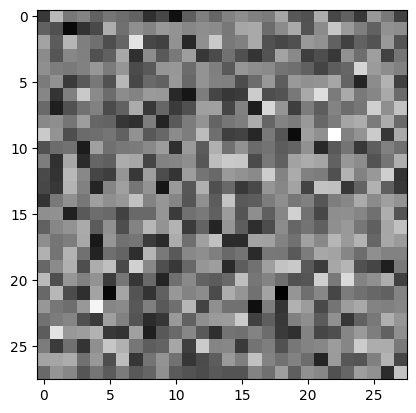

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = torch.randn((1, 100), device=device)
c = torch.zeros((1, num_classes), device=device)
G.eval()    # 생성자 G를 함수로 쓸 때는 eval로 설정해야 함.
fake_image_test = G(test_noise, c)

plt.imshow(fake_image_test.reshape(28, 28).cpu().detach().numpy(), cmap='gray')

In [ ]:
# Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.
D.eval()    # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
decision = D(fake_image_test, c)

print(decision)

tensor([[0.4855]], device='cuda:0', grad_fn=<SigmoidBackward0>)


## GAN 목적함수
GAN의 목적함수는 다음과 같다.

$$
\begin{align}
    \min_{G}\max_{D} V(G, D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$

### Discriminator Loss
판별자 D 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최대화 문제를 풀고자 한다.
$$
\begin{align}
    \max_{D} V(D) = \mathbb{E}_{\mathbf{x} \sim p_{\textit{data}}(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(\mathbf{x}_{\textrm{fake}}))]
\end{align}
$$

### Generator Loss
생성자 G 입장에서는 GAN 목적함수를 다음과 같이 해석하고, 최소화 문제를 풀고자 한다.
$$
\begin{align}
    \min_{G} V(G) = \mathbb{E}_{\mathbf{z} \sim p_\mathbf{z}(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]
\end{align}
$$

In [ ]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의
criterion = torch.nn.BCELoss()

# GAN 트레이닝에 쓰일 optimizer 정의
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

![GAN](https://cdn-images-1.medium.com/max/800/1*XKanAdkjQbg1eDDMF2-4ow.png)

[이미지 출처: Branko Blagojevic's Medium Post](https://medium.com/ml-everything/generating-letters-using-generative-adversarial-networks-gans-161b0be3c229)

## Training

마이크 타이슨의 명언: **누구나 그럴싸한 계획을 가지고 있다... 얻어맞기 전까지는...**
![대체 텍스트](https://cdn-images-1.medium.com/max/800/1*ocjDDF4WbSZl-WAFVUlqrg.jpeg)

## TODO (2)

1. 고정된 noise 값을 몇 개 생성한다.
2. Training 과정 중 일정 시점마다 (ex. epoch % 10 == 0) <br> network G가 (1)의 noise 값으로부터 만들어낸 가짜 데이터를 가시화 하여, 학습이 진행되며 어떻게 변화하는지 확인한다.


## TODO (3)

매 epoch마다 network G와 network D의 loss를 저장한 뒤 그래프로 가시화 한다. 각 network의 loss가 어떻게 변화하는지 논의한다.

<br><br>

(학습이 충분이 진행되지 않았다고 판단될 경우 epoch 횟수를 늘리거나 다른 의미있는 변화들을 추가해 본다.)

# TODO (2) 결과

torch.randn 함수를 활용해 Generator에 입력으로 줄 noise 값을 생성하였습니다. 그리고 Generator에 noises와 one_hot_label을 입력으로 주어 가짜 이미지 데이터를 생성하고, 이를 epoch % 10 == 0일 때마다 가시화하였습니다.

0번 째 epoch일 때보다 10번 째 epoch일 때, 10번 째보다 20번 째일 때, 학습을 진행하면 할 수록 더욱 더 선명한 숫자 이미지 데이터를 생성하는 것을 확인할 수 있었습니다.

이를 통해, Generator가 학습이 진행되면서 어떻게 가짜 데이터를 생성하는지, 그리고 이 가짜 데이터가 어떻게 변화하는지 시각적으로 확인할 수 있었습니다.


# TODO (3) 결과

매 epoch 마다 network G와 network D의 loss를 train_hist 라는 딕셔너리에 저장한 뒤 그래프로 가시화 하였습니다.

network D의 Loss는 D_real_loss와 D_fake_loss의 합으로 구성되어 있습니다. D_real_loss는 실제 데이터에 대한 판별값과 1 사이의 차이를 계산하고, D_fake_loss는 가짜 데이터에 대한 판별값과 0 사이의 차이를 계산합니다.

각 epoch마다 loss 값이 줄어들거라고 예상하였지만 그래프를 보면 loss가 계속해서 줄어드는 것이 아니라 network G의 Loss값과 비슷한 값으로 수렴하는 것을 확인할 수 있었습니다.

이는 discriminator와 generator가 서로 경쟁하며 학습하는 구조이기 때문에 그렇다고 생각하였습니다. 서로의 손실 값을 최소화하려는 경쟁이 진행되기 때문에, 그 결과로 학습이 진행되면서 discriminator와 generator의 손실 값이 비슷한 값으로 수렴하게 된다고 생각합니다.

network G의 Loss는 G_loss로 계산되며, 이는 가짜 데이터에 대한 판별값과 1 사이의 차이를 계산합니다. Generator는 가짜 데이터를 생성하고 이를 Discriminator에 판별시키는데, 이때 Discriminator가 가짜 데이터를 실제 데이터로 오인할수록 G_loss가 작아집니다.

network G 역시 각 epoch마다 loss 값이 줄어들거라고 예상하였습니다. 0번째 epoch을 제외하고는 학습을 진행하면서 계속해서 G_loss 값이 줄어드는 것을 확인할 수 있었습니다. 그리고 network G 역시 network D의 Loss값과 비슷한 값으로 수렴하는 것을 확인할 수 있었습니다.

## epoch 횟수 늘리기

학습의 결과 생성자(generator)가 생성한 가짜 데이터(G(z))를 판별자(discriminator)에 입력하여 얻은 출력값을 나타낸 D(G(z)) 값이 0.3368 / 0.3256 = 1.0343..으로 1에 가까워 생성자가 진짜 데이터와 유사한 가짜 데이터를 생성하고 있다고 생각하였지만, 제네레이터로 만든 0~9까지의 숫자의 형태가 희미하고 흐릿하다고 생각하여 epoch을 100회까지 늘려서 학습을 진행해보았습니다.

100회 진행하였을 때는 마지막 epoch의 결과가

[99/100][200/235]	Loss_D: 1.2363	Loss_G: 0.9402	D(x): 0.5690	D(G(z)): 0.4384 / 0.4226

이렇게 나왔고, 그래프 역시 D_loss와 G_loss가 비슷한 값으로 수렴하게 그려졌습니다.

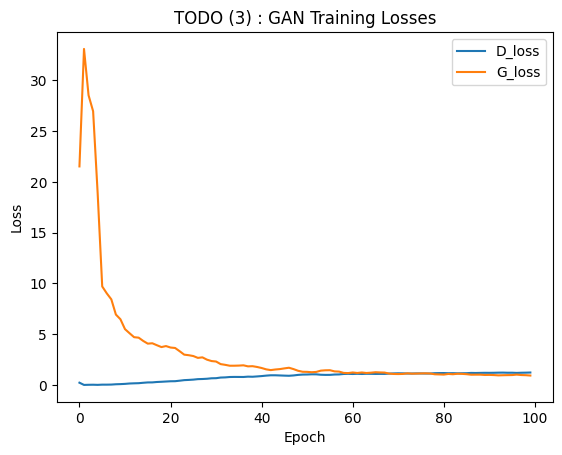

성능에는 크게 차이가 없다고 판단하였지만 제네레이터가 생성하는 이미지는 50회로 학습했을 때보다 선명해진 결과가 나왔습니다.

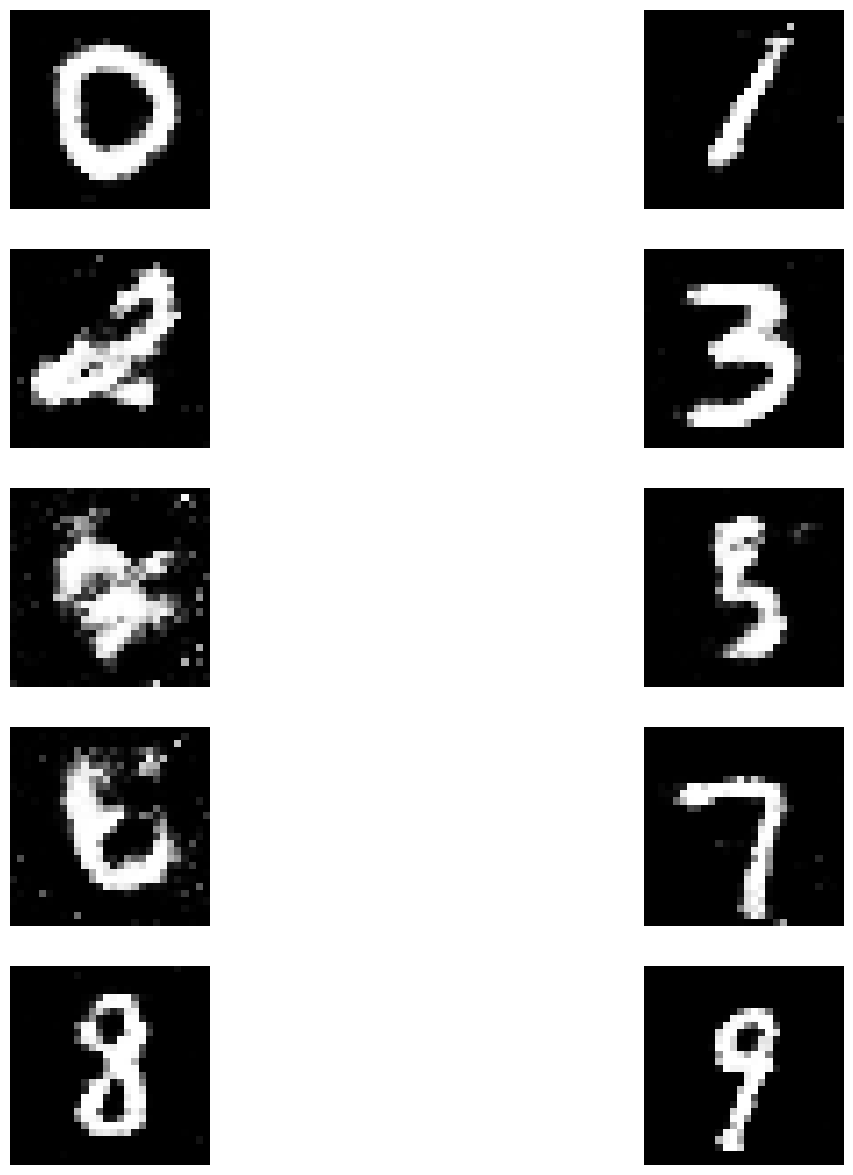

[0/50][0/235]	Loss_D: 1.3839	Loss_G: 0.7271	D(x): 0.4852	D(G(z)): 0.4833 / 0.4833
[0/50][50/235]	Loss_D: 0.1203	Loss_G: 4.5504	D(x): 0.9612	D(G(z)): 0.0740 / 0.0152
[0/50][100/235]	Loss_D: 0.2438	Loss_G: 19.3789	D(x): 0.9940	D(G(z)): 0.1866 / 0.1672
[0/50][150/235]	Loss_D: 0.0913	Loss_G: 30.0021	D(x): 0.9889	D(G(z)): 0.0640 / 0.0433
[0/50][200/235]	Loss_D: 0.0096	Loss_G: 33.9757	D(x): 1.0000	D(G(z)): 0.0094 / 0.0066


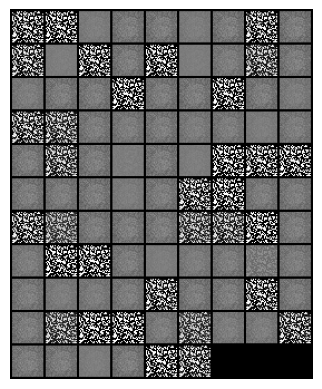

[1/50][0/235]	Loss_D: 0.0152	Loss_G: 35.8897	D(x): 0.9951	D(G(z)): 0.0034 / 0.0028
[1/50][50/235]	Loss_D: 0.0040	Loss_G: 32.8408	D(x): 0.9999	D(G(z)): 0.0039 / 0.0023
[1/50][100/235]	Loss_D: 0.1280	Loss_G: 34.2206	D(x): 0.9770	D(G(z)): 0.0002 / 0.0031
[1/50][150/235]	Loss_D: 0.0211	Loss_G: 30.6720	D(x): 1.0000	D(G(z)): 0.0180 / 0.0192
[1/50][200/235]	Loss_D: 0.0365	Loss_G: 33.4244	D(x): 0.9969	D(G(z)): 0.0239 / 0.0056
[2/50][0/235]	Loss_D: 0.0516	Loss_G: 31.1893	D(x): 0.9761	D(G(z)): 0.0035 / 0.0051
[2/50][50/235]	Loss_D: 0.1080	Loss_G: 30.4142	D(x): 0.9639	D(G(z)): 0.0244 / 0.0172
[2/50][100/235]	Loss_D: 0.0180	Loss_G: 29.4006	D(x): 0.9933	D(G(z)): 0.0097 / 0.0077
[2/50][150/235]	Loss_D: 0.0325	Loss_G: 27.0869	D(x): 0.9945	D(G(z)): 0.0188 / 0.0109
[2/50][200/235]	Loss_D: 0.0515	Loss_G: 29.6165	D(x): 0.9901	D(G(z)): 0.0281 / 0.0099
[3/50][0/235]	Loss_D: 0.0894	Loss_G: 26.0301	D(x): 0.9846	D(G(z)): 0.0486 / 0.0089
[3/50][50/235]	Loss_D: 0.0389	Loss_G: 24.7508	D(x): 0.9994	D(G(z)): 0.025

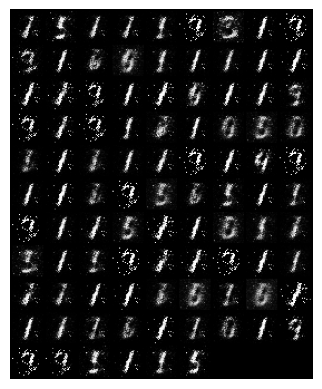

[11/50][0/235]	Loss_D: 0.2787	Loss_G: 6.1426	D(x): 0.9058	D(G(z)): 0.0039 / 0.0081
[11/50][50/235]	Loss_D: 0.0835	Loss_G: 5.0669	D(x): 0.9652	D(G(z)): 0.0159 / 0.0281
[11/50][100/235]	Loss_D: 0.1318	Loss_G: 5.1775	D(x): 0.9713	D(G(z)): 0.0336 / 0.0334
[11/50][150/235]	Loss_D: 0.1306	Loss_G: 5.5323	D(x): 0.9609	D(G(z)): 0.0215 / 0.0189
[11/50][200/235]	Loss_D: 0.1761	Loss_G: 4.3297	D(x): 0.9537	D(G(z)): 0.0441 / 0.0603
[12/50][0/235]	Loss_D: 0.2128	Loss_G: 5.4346	D(x): 0.9832	D(G(z)): 0.1096 / 0.0152
[12/50][50/235]	Loss_D: 0.1196	Loss_G: 5.0546	D(x): 0.9629	D(G(z)): 0.0133 / 0.0238
[12/50][100/235]	Loss_D: 0.1273	Loss_G: 5.6382	D(x): 0.9529	D(G(z)): 0.0130 / 0.0127
[12/50][150/235]	Loss_D: 0.0885	Loss_G: 5.0342	D(x): 0.9882	D(G(z)): 0.0531 / 0.0345
[12/50][200/235]	Loss_D: 0.1112	Loss_G: 4.7647	D(x): 0.9733	D(G(z)): 0.0365 / 0.0259
[13/50][0/235]	Loss_D: 0.0744	Loss_G: 5.9552	D(x): 0.9852	D(G(z)): 0.0314 / 0.0144
[13/50][50/235]	Loss_D: 0.1513	Loss_G: 4.9185	D(x): 0.9379	D(G(z)): 0.012

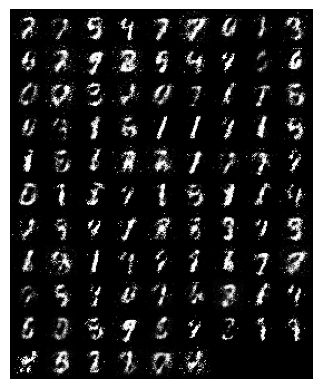

[21/50][0/235]	Loss_D: 0.2808	Loss_G: 3.8242	D(x): 0.9046	D(G(z)): 0.0735 / 0.0872
[21/50][50/235]	Loss_D: 0.3358	Loss_G: 3.9323	D(x): 0.9042	D(G(z)): 0.0940 / 0.0850
[21/50][100/235]	Loss_D: 0.3657	Loss_G: 3.1083	D(x): 0.8820	D(G(z)): 0.1141 / 0.1182
[21/50][150/235]	Loss_D: 0.3156	Loss_G: 4.1188	D(x): 0.9096	D(G(z)): 0.1196 / 0.0748
[21/50][200/235]	Loss_D: 0.3313	Loss_G: 4.2355	D(x): 0.8940	D(G(z)): 0.0934 / 0.0677
[22/50][0/235]	Loss_D: 0.3960	Loss_G: 4.0354	D(x): 0.8814	D(G(z)): 0.0910 / 0.0838
[22/50][50/235]	Loss_D: 0.4438	Loss_G: 3.1515	D(x): 0.9251	D(G(z)): 0.2001 / 0.1020
[22/50][100/235]	Loss_D: 0.3233	Loss_G: 4.0423	D(x): 0.9200	D(G(z)): 0.1220 / 0.0803
[22/50][150/235]	Loss_D: 0.3743	Loss_G: 3.4054	D(x): 0.8735	D(G(z)): 0.0942 / 0.1040
[22/50][200/235]	Loss_D: 0.4859	Loss_G: 2.5934	D(x): 0.8815	D(G(z)): 0.1851 / 0.1797
[23/50][0/235]	Loss_D: 0.4575	Loss_G: 3.6735	D(x): 0.8447	D(G(z)): 0.0780 / 0.1195
[23/50][50/235]	Loss_D: 0.4597	Loss_G: 3.4157	D(x): 0.8415	D(G(z)): 0.097

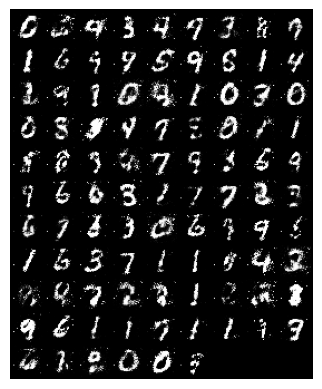

[31/50][0/235]	Loss_D: 0.6571	Loss_G: 2.5445	D(x): 0.7620	D(G(z)): 0.1919 / 0.1607
[31/50][50/235]	Loss_D: 0.6291	Loss_G: 2.4130	D(x): 0.8069	D(G(z)): 0.1967 / 0.2204
[31/50][100/235]	Loss_D: 0.7000	Loss_G: 2.6300	D(x): 0.7769	D(G(z)): 0.2390 / 0.1567
[31/50][150/235]	Loss_D: 0.7238	Loss_G: 2.1785	D(x): 0.7304	D(G(z)): 0.1671 / 0.2114
[31/50][200/235]	Loss_D: 0.8547	Loss_G: 2.4143	D(x): 0.7218	D(G(z)): 0.2152 / 0.1947
[32/50][0/235]	Loss_D: 0.6959	Loss_G: 2.1157	D(x): 0.8274	D(G(z)): 0.2840 / 0.2141
[32/50][50/235]	Loss_D: 0.7115	Loss_G: 2.3724	D(x): 0.7748	D(G(z)): 0.2295 / 0.1890
[32/50][100/235]	Loss_D: 0.6323	Loss_G: 2.6697	D(x): 0.8803	D(G(z)): 0.2934 / 0.1480
[32/50][150/235]	Loss_D: 0.8101	Loss_G: 1.7556	D(x): 0.7609	D(G(z)): 0.3039 / 0.2544
[32/50][200/235]	Loss_D: 0.6838	Loss_G: 2.2758	D(x): 0.7629	D(G(z)): 0.2349 / 0.1778
[33/50][0/235]	Loss_D: 0.7561	Loss_G: 2.5143	D(x): 0.7871	D(G(z)): 0.2483 / 0.1959
[33/50][50/235]	Loss_D: 0.6633	Loss_G: 1.9679	D(x): 0.8302	D(G(z)): 0.267

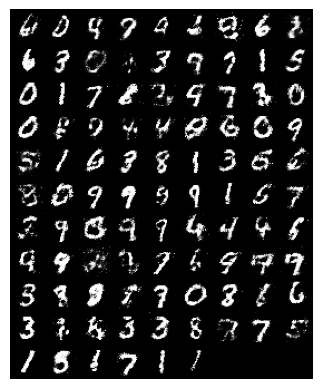

[41/50][0/235]	Loss_D: 0.9819	Loss_G: 1.5158	D(x): 0.6825	D(G(z)): 0.3426 / 0.2911
[41/50][50/235]	Loss_D: 0.9578	Loss_G: 1.6205	D(x): 0.7191	D(G(z)): 0.3423 / 0.2658
[41/50][100/235]	Loss_D: 0.9463	Loss_G: 1.5144	D(x): 0.6877	D(G(z)): 0.3189 / 0.2896
[41/50][150/235]	Loss_D: 0.9513	Loss_G: 1.6302	D(x): 0.6622	D(G(z)): 0.2898 / 0.3010
[41/50][200/235]	Loss_D: 0.9802	Loss_G: 1.3770	D(x): 0.6742	D(G(z)): 0.3299 / 0.3238
[42/50][0/235]	Loss_D: 1.0307	Loss_G: 1.4666	D(x): 0.6707	D(G(z)): 0.3300 / 0.3183
[42/50][50/235]	Loss_D: 0.9966	Loss_G: 1.6274	D(x): 0.6755	D(G(z)): 0.3079 / 0.3085
[42/50][100/235]	Loss_D: 0.8874	Loss_G: 1.6103	D(x): 0.6533	D(G(z)): 0.2652 / 0.2685
[42/50][150/235]	Loss_D: 0.8298	Loss_G: 2.1234	D(x): 0.7076	D(G(z)): 0.2467 / 0.2068
[42/50][200/235]	Loss_D: 0.9245	Loss_G: 1.7338	D(x): 0.7004	D(G(z)): 0.3147 / 0.2607
[43/50][0/235]	Loss_D: 0.8779	Loss_G: 1.7528	D(x): 0.7061	D(G(z)): 0.3074 / 0.2664
[43/50][50/235]	Loss_D: 0.9271	Loss_G: 1.6362	D(x): 0.6826	D(G(z)): 0.322

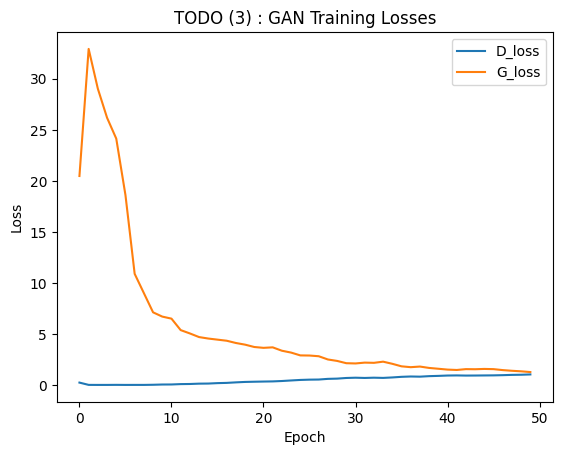

Training Finished!


In [ ]:
import math

G.train()
D.train()

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(EPOCHS):
  D_losses = []
  G_losses = []

  for i, (images, labels) in enumerate(train_loader):
    #############################
    # 1) Update discriminator D #
    #############################
    D.zero_grad()

    images_real = images.to(device)
    labels = labels.to(device)
    one_hot_label = torch.zeros((labels.size(0), num_classes), device=device)
    one_hot_label.scatter_(1, labels.unsqueeze(1), 1)  # one-hot 벡터로 변환
    y_pred_real = D(images_real, one_hot_label).view(-1)    # 진짜 MNIST 데이터를 본 Discriminator의 판별값
    label = torch.full((images_real.size(0),), 1., dtype=torch.float, device=device)    # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network D가 진짜 데이터를 진짜로 판별했는지를 평가
    D_real_loss = criterion(y_pred_real, label)
    D_real_loss.backward()

    D_x = y_pred_real.mean().item()

    # 가짜 데이터 생성
    noises = torch.randn([images_real.size(0), noise_dim], device=device)   # Generator에 입력으로 줄 noise
    images_fake = G(noises, one_hot_label)           # Generator는 noise로부터 가짜 데이터를 생성

    y_pred_fake = D(images_fake.detach(), one_hot_label).view(-1)      # Generator가 만든 가짜 데이터를 본 Discriminator의 판별값
    label.fill_(0.)        # 가짜 데이터에 대한 label 값은 0

    # Network D가 가짜 데이터를 가짜로 판별했는지를 평가
    D_fake_loss = criterion(y_pred_fake, label)
    D_fake_loss.backward()

    D_G_z1 = y_pred_fake.mean().item()

    D_loss = D_real_loss + D_fake_loss

    # Update D
    D_optimizer.step()

    #############################
    # 2) Update discriminator G #
    #############################
    G.zero_grad()

    y_pred_fake = D(images_fake, one_hot_label).view(-1)
    label.fill_(1.)       # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network G가 생선한 가짜 데이터를 D가 진짜라고 판별했는지를 평가한다.
    G_loss = criterion(y_pred_fake, label)
    G_loss.backward()

    D_G_z2 = y_pred_fake.mean().item()

    # Update G
    G_optimizer.step()

    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(train_loader),
                     D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))

    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())

    # 일정 시점에서 (ex. epoch % 10 == 0) network G가 생성한 가짜 데이터를 가시화하여 변화를 확인한다.

  train_hist['D_losses'].append(torch.mean(torch.Tensor(D_losses)))
  train_hist['G_losses'].append(torch.mean(torch.Tensor(G_losses)))
  if epoch % 10 == 0:
        with torch.no_grad():
            fixed_images_fake = G(noises, one_hot_label)  # 고정된 noise 값으로부터 가짜 데이터를 생성
            fixed_images_fake = fixed_images_fake.view(-1, 1, 28, 28)  # 이미지 형태로 변환

            # 가시화를 위해 이미지를 그리드 형태로 배치하여 시각화
            grid = torchvision.utils.make_grid(fixed_images_fake, nrow=int(math.sqrt(images_real.size(0))), normalize=True)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

plt.plot(train_hist['D_losses'], label='D_loss')
plt.plot(train_hist['G_losses'], label='G_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TODO (3) : GAN Training Losses')
plt.show()
print('Training Finished!')

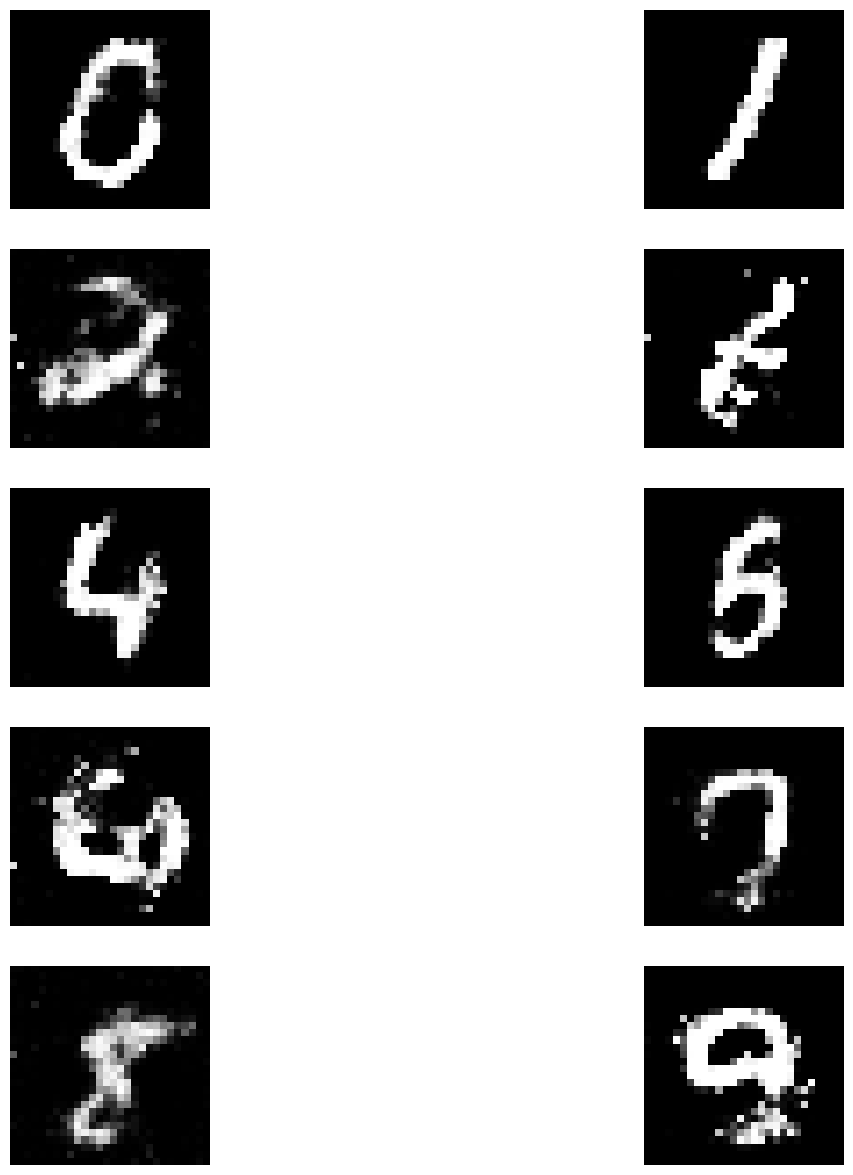

In [ ]:
import matplotlib.pyplot as plt

G.eval()
noises = torch.randn(10, 100, device=device)
labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device=device, dtype=torch.long).view(-1, 1)
one_hot_label = torch.zeros(10, num_classes, device=device).scatter_(1, labels, 1)
generated_image = G(noises, one_hot_label).cpu().detach().numpy().squeeze()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()


## TODO (4)

위의 내용을 noise의 dim 값을 바꾸어 실험해 본다.

# TODO (4) 결과

noise_dim을 100에서 각각 10과 500으로 바꾸어서 실험해보았습니다.

실험한 결과 차원이 10일 때, 100일 떄, 500일 때 모두 loss 그래프의 형태가 비슷하게 생성되었습니다. network G의 loss는 0번 째 epoch일 때를 제외하고 계속 감소하여 network D의 loss 값에 가깝게 수렴했고, network D 역시 network G의 loss 값에 가깝게 수렴하는 모습을 보여줬습니다.

허나 제네레이터가 생성하는 이미지 데이터는 다른 점이 있었습니다. 차원이 10일 때는 제네레이터가 생성하는 이미지의 품질이 좋지 않았으나, 차원이 올라갈 수록 보다 선명한 이미지 데이터를 생성해냈습니다.

결과적으로 noise 벡터의 차원이 network G의 모델 성능에 영향을 끼친다는 것을 알 수 있었습니다.

In [ ]:
noise_dim = 10

In [ ]:
## TODO
num_classes = 10

class CondGenerator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(noise_dim + num_classes, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 1 * 28 * 28)

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(1024)

        self.lrelu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

    def generator(self, z, c):
        x = torch.cat([z, c], dim=1)
        x = self.lrelu(self.bn1(self.fc1(x)))
        x = self.lrelu(self.bn2(self.fc2(x)))
        x = self.lrelu(self.bn3(self.fc3(x)))
        x = self.tanh(self.fc4(x))
        x = x.view(-1, 1, 28, 28)

        return x

    def forward(self, z, c):
        z = self.generator(z, c)

        return z

G = CondGenerator().to(device)

In [ ]:
from torchinfo import summary

summary(G, [(BATCH_SIZE, noise_dim), (BATCH_SIZE, 10)])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
CondGenerator                            [256, 1, 28, 28]          --
├─Linear: 1-1                            [256, 256]                5,376
├─BatchNorm1d: 1-2                       [256, 256]                512
├─LeakyReLU: 1-3                         [256, 256]                --
├─Linear: 1-4                            [256, 512]                131,584
├─BatchNorm1d: 1-5                       [256, 512]                1,024
├─LeakyReLU: 1-6                         [256, 512]                --
├─Linear: 1-7                            [256, 1024]               525,312
├─BatchNorm1d: 1-8                       [256, 1024]               2,048
├─LeakyReLU: 1-9                         [256, 1024]               --
├─Linear: 1-10                           [256, 784]                803,600
├─Tanh: 1-11                             [256, 784]                --
Total params: 1,469,456
Trainable params: 1,469,456
Non-trai

In [ ]:
## TODO
class CondDiscriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1 * 28 * 28 + num_classes, 1024)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 1)

        self.lrelu = torch.nn.LeakyReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.3)

    def discriminator(self, z, c):
        x = torch.cat([z.view(-1, 1 * 28 * 28), c], dim=1)
        x = self.dropout(self.lrelu(self.fc1(x)))
        x = self.dropout(self.lrelu(self.fc2(x)))
        x = self.dropout(self.lrelu(self.fc3(x)))
        x = self.fc4(x)
        x = self.sigmoid(x)

        return x

    def forward(self, z, c):
        z = self.discriminator(z, c)

        return z


D = CondDiscriminator().to(device)

In [ ]:
summary(D, [(BATCH_SIZE, 1, 28, 28), (BATCH_SIZE, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
CondDiscriminator                        [256, 1]                  --
├─Linear: 1-1                            [256, 1024]               814,080
├─LeakyReLU: 1-2                         [256, 1024]               --
├─Dropout: 1-3                           [256, 1024]               --
├─Linear: 1-4                            [256, 512]                524,800
├─LeakyReLU: 1-5                         [256, 512]                --
├─Dropout: 1-6                           [256, 512]                --
├─Linear: 1-7                            [256, 256]                131,328
├─LeakyReLU: 1-8                         [256, 256]                --
├─Dropout: 1-9                           [256, 256]                --
├─Linear: 1-10                           [256, 1]                  257
├─Sigmoid: 1-11                          [256, 1]                  --
Total params: 1,470,465
Trainable params: 1,470,465
Non-trainable par

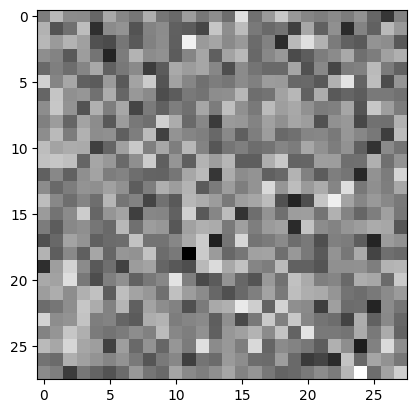

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = torch.randn((1, noise_dim), device=device)
c = torch.zeros((1, num_classes), device=device)
G.eval()    # 생성자 G를 함수로 쓸 때는 eval로 설정해야 함.
fake_image_test = G(test_noise, c)

plt.imshow(fake_image_test.reshape(28, 28).cpu().detach().numpy(), cmap='gray')

In [ ]:
# Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.
D.eval()    # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
decision = D(fake_image_test, c)

print(decision)

tensor([[0.5056]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의
criterion = torch.nn.BCELoss()

# GAN 트레이닝에 쓰일 optimizer 정의
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

[0/50][0/235]	Loss_D: 1.3678	Loss_G: 0.6793	D(x): 0.5172	D(G(z)): 0.5075 / 0.5070
[0/50][50/235]	Loss_D: 0.1676	Loss_G: 4.9538	D(x): 0.9398	D(G(z)): 0.0857 / 0.0167
[0/50][100/235]	Loss_D: 0.1121	Loss_G: 17.3864	D(x): 0.9989	D(G(z)): 0.1018 / 0.0832
[0/50][150/235]	Loss_D: 0.0179	Loss_G: 28.0035	D(x): 0.9993	D(G(z)): 0.0170 / 0.0133
[0/50][200/235]	Loss_D: 0.0085	Loss_G: 29.1499	D(x): 0.9977	D(G(z)): 0.0049 / 0.0048


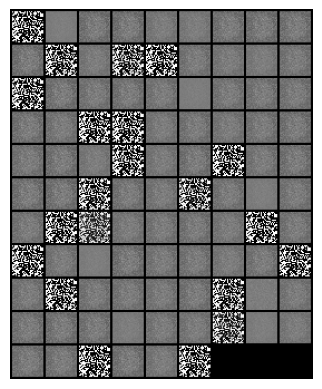

[1/50][0/235]	Loss_D: 0.0034	Loss_G: 30.5629	D(x): 1.0000	D(G(z)): 0.0034 / 0.0011
[1/50][50/235]	Loss_D: 0.0037	Loss_G: 29.9405	D(x): 0.9999	D(G(z)): 0.0036 / 0.0030
[1/50][100/235]	Loss_D: 0.0065	Loss_G: 28.2526	D(x): 0.9984	D(G(z)): 0.0046 / 0.0005
[1/50][150/235]	Loss_D: 0.0603	Loss_G: 25.7924	D(x): 0.9831	D(G(z)): 0.0269 / 0.0046
[1/50][200/235]	Loss_D: 0.0414	Loss_G: 25.0133	D(x): 0.9965	D(G(z)): 0.0331 / 0.0145
[2/50][0/235]	Loss_D: 0.0331	Loss_G: 23.7734	D(x): 0.9895	D(G(z)): 0.0190 / 0.0048
[2/50][50/235]	Loss_D: 0.0935	Loss_G: 24.5251	D(x): 0.9752	D(G(z)): 0.0342 / 0.0087
[2/50][100/235]	Loss_D: 0.1946	Loss_G: 25.0783	D(x): 0.9104	D(G(z)): 0.0210 / 0.0135
[2/50][150/235]	Loss_D: 0.0795	Loss_G: 22.8758	D(x): 0.9518	D(G(z)): 0.0123 / 0.0010
[2/50][200/235]	Loss_D: 0.0557	Loss_G: 20.8629	D(x): 0.9793	D(G(z)): 0.0246 / 0.0084
[3/50][0/235]	Loss_D: 0.1520	Loss_G: 21.0643	D(x): 0.9260	D(G(z)): 0.0315 / 0.0088
[3/50][50/235]	Loss_D: 0.0758	Loss_G: 22.0048	D(x): 0.9894	D(G(z)): 0.047

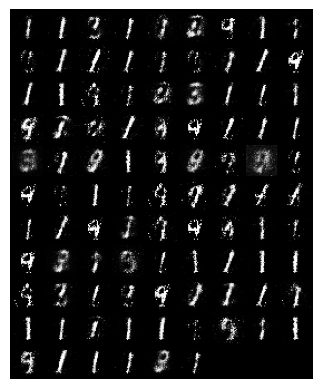

[11/50][0/235]	Loss_D: 0.1670	Loss_G: 4.7612	D(x): 0.9336	D(G(z)): 0.0295 / 0.0423
[11/50][50/235]	Loss_D: 0.2532	Loss_G: 4.7198	D(x): 0.9411	D(G(z)): 0.0795 / 0.0309
[11/50][100/235]	Loss_D: 0.1634	Loss_G: 4.1956	D(x): 0.9439	D(G(z)): 0.0520 / 0.0494
[11/50][150/235]	Loss_D: 0.2071	Loss_G: 4.8333	D(x): 0.9672	D(G(z)): 0.0964 / 0.0412
[11/50][200/235]	Loss_D: 0.3010	Loss_G: 3.2613	D(x): 0.9340	D(G(z)): 0.0984 / 0.1128
[12/50][0/235]	Loss_D: 0.1814	Loss_G: 4.3863	D(x): 0.9559	D(G(z)): 0.0691 / 0.0605
[12/50][50/235]	Loss_D: 0.2218	Loss_G: 4.8661	D(x): 0.9664	D(G(z)): 0.0942 / 0.0483
[12/50][100/235]	Loss_D: 0.3176	Loss_G: 3.8358	D(x): 0.8983	D(G(z)): 0.0660 / 0.0696
[12/50][150/235]	Loss_D: 0.2388	Loss_G: 4.0765	D(x): 0.9291	D(G(z)): 0.0707 / 0.0591
[12/50][200/235]	Loss_D: 0.2456	Loss_G: 3.5374	D(x): 0.9261	D(G(z)): 0.0870 / 0.0837
[13/50][0/235]	Loss_D: 0.2599	Loss_G: 4.3484	D(x): 0.9019	D(G(z)): 0.0573 / 0.0426
[13/50][50/235]	Loss_D: 0.3675	Loss_G: 3.0465	D(x): 0.8847	D(G(z)): 0.097

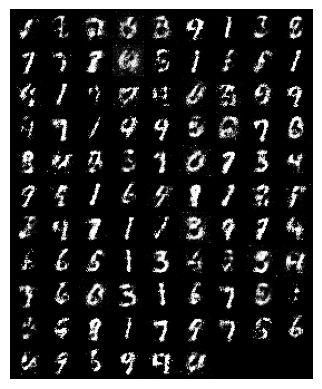

[21/50][0/235]	Loss_D: 0.6270	Loss_G: 2.5010	D(x): 0.7775	D(G(z)): 0.1620 / 0.1515
[21/50][50/235]	Loss_D: 0.6454	Loss_G: 2.1579	D(x): 0.8126	D(G(z)): 0.2385 / 0.1928
[21/50][100/235]	Loss_D: 0.6134	Loss_G: 2.7175	D(x): 0.7984	D(G(z)): 0.1629 / 0.1935
[21/50][150/235]	Loss_D: 0.4892	Loss_G: 3.0079	D(x): 0.8291	D(G(z)): 0.1448 / 0.1465
[21/50][200/235]	Loss_D: 0.8573	Loss_G: 2.4029	D(x): 0.7839	D(G(z)): 0.2835 / 0.2270
[22/50][0/235]	Loss_D: 0.5920	Loss_G: 2.8497	D(x): 0.9044	D(G(z)): 0.2641 / 0.1467
[22/50][50/235]	Loss_D: 0.6169	Loss_G: 3.0297	D(x): 0.8097	D(G(z)): 0.2132 / 0.1331
[22/50][100/235]	Loss_D: 0.6481	Loss_G: 2.3524	D(x): 0.7656	D(G(z)): 0.1722 / 0.1875
[22/50][150/235]	Loss_D: 0.6627	Loss_G: 2.7482	D(x): 0.7760	D(G(z)): 0.2196 / 0.1595
[22/50][200/235]	Loss_D: 0.6135	Loss_G: 3.0104	D(x): 0.7876	D(G(z)): 0.1575 / 0.1425
[23/50][0/235]	Loss_D: 0.5792	Loss_G: 3.1989	D(x): 0.8163	D(G(z)): 0.1954 / 0.1240
[23/50][50/235]	Loss_D: 0.6245	Loss_G: 2.3713	D(x): 0.7932	D(G(z)): 0.152

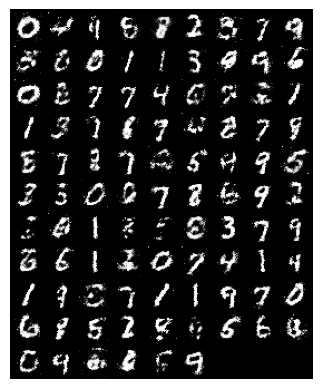

[31/50][0/235]	Loss_D: 0.6737	Loss_G: 2.1347	D(x): 0.7507	D(G(z)): 0.2034 / 0.2250
[31/50][50/235]	Loss_D: 0.7645	Loss_G: 2.4123	D(x): 0.7836	D(G(z)): 0.2775 / 0.1827
[31/50][100/235]	Loss_D: 0.8124	Loss_G: 1.8841	D(x): 0.7300	D(G(z)): 0.2798 / 0.2355
[31/50][150/235]	Loss_D: 0.8798	Loss_G: 1.3888	D(x): 0.7237	D(G(z)): 0.2946 / 0.3480
[31/50][200/235]	Loss_D: 0.8920	Loss_G: 1.7738	D(x): 0.7420	D(G(z)): 0.3205 / 0.2585
[32/50][0/235]	Loss_D: 0.9055	Loss_G: 1.4973	D(x): 0.6957	D(G(z)): 0.2837 / 0.3142
[32/50][50/235]	Loss_D: 0.9329	Loss_G: 1.4567	D(x): 0.6996	D(G(z)): 0.3117 / 0.3206
[32/50][100/235]	Loss_D: 1.0517	Loss_G: 1.4534	D(x): 0.7424	D(G(z)): 0.3974 / 0.3197
[32/50][150/235]	Loss_D: 0.9443	Loss_G: 1.5279	D(x): 0.6314	D(G(z)): 0.2719 / 0.2810
[32/50][200/235]	Loss_D: 0.9801	Loss_G: 1.5826	D(x): 0.6231	D(G(z)): 0.2819 / 0.2765
[33/50][0/235]	Loss_D: 0.8641	Loss_G: 1.5998	D(x): 0.7436	D(G(z)): 0.3250 / 0.2917
[33/50][50/235]	Loss_D: 0.8072	Loss_G: 2.0133	D(x): 0.7083	D(G(z)): 0.241

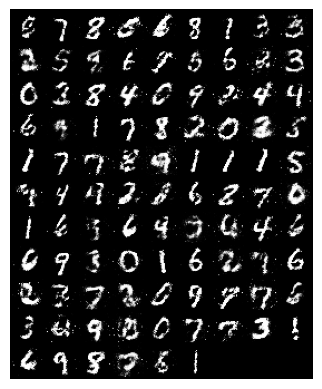

[41/50][0/235]	Loss_D: 1.1065	Loss_G: 1.1433	D(x): 0.6595	D(G(z)): 0.3995 / 0.3787
[41/50][50/235]	Loss_D: 1.0917	Loss_G: 1.1898	D(x): 0.6519	D(G(z)): 0.3856 / 0.3635
[41/50][100/235]	Loss_D: 1.1639	Loss_G: 1.2806	D(x): 0.6559	D(G(z)): 0.3953 / 0.3574
[41/50][150/235]	Loss_D: 1.0472	Loss_G: 1.3727	D(x): 0.6281	D(G(z)): 0.3532 / 0.3241
[41/50][200/235]	Loss_D: 1.0603	Loss_G: 1.2131	D(x): 0.6679	D(G(z)): 0.3838 / 0.3542
[42/50][0/235]	Loss_D: 1.1225	Loss_G: 1.3190	D(x): 0.6699	D(G(z)): 0.3924 / 0.3443
[42/50][50/235]	Loss_D: 1.0210	Loss_G: 1.6867	D(x): 0.6364	D(G(z)): 0.2694 / 0.3006
[42/50][100/235]	Loss_D: 1.0482	Loss_G: 1.7862	D(x): 0.6855	D(G(z)): 0.3613 / 0.2663
[42/50][150/235]	Loss_D: 1.0125	Loss_G: 1.9849	D(x): 0.6679	D(G(z)): 0.3016 / 0.2341
[42/50][200/235]	Loss_D: 0.9419	Loss_G: 2.0073	D(x): 0.7045	D(G(z)): 0.3252 / 0.2478
[43/50][0/235]	Loss_D: 0.9746	Loss_G: 1.9557	D(x): 0.6285	D(G(z)): 0.2527 / 0.2572
[43/50][50/235]	Loss_D: 0.7975	Loss_G: 2.0843	D(x): 0.6790	D(G(z)): 0.201

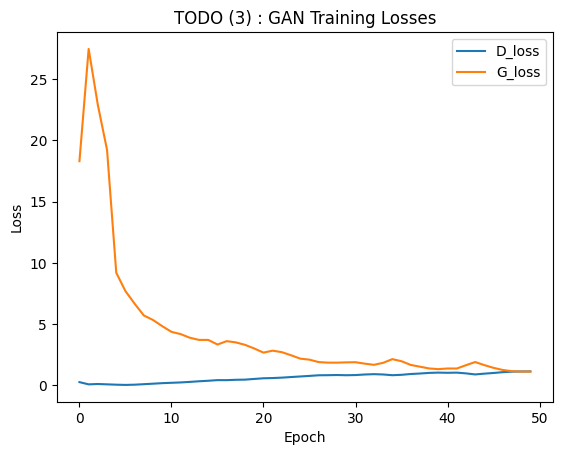

Training Finished!


In [ ]:
import math

G.train()
D.train()

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(EPOCHS):
  D_losses = []
  G_losses = []

  for i, (images, labels) in enumerate(train_loader):
    #############################
    # 1) Update discriminator D #
    #############################
    D.zero_grad()

    images_real = images.to(device)
    labels = labels.to(device)
    one_hot_label = torch.zeros((labels.size(0), num_classes), device=device)
    one_hot_label.scatter_(1, labels.unsqueeze(1), 1)  # one-hot 벡터로 변환
    y_pred_real = D(images_real, one_hot_label).view(-1)    # 진짜 MNIST 데이터를 본 Discriminator의 판별값
    label = torch.full((images_real.size(0),), 1., dtype=torch.float, device=device)    # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network D가 진짜 데이터를 진짜로 판별했는지를 평가
    D_real_loss = criterion(y_pred_real, label)
    D_real_loss.backward()

    D_x = y_pred_real.mean().item()

    # 가짜 데이터 생성
    noises = torch.randn([images_real.size(0), noise_dim], device=device)   # Generator에 입력으로 줄 noise
    images_fake = G(noises, one_hot_label)           # Generator는 noise로부터 가짜 데이터를 생성

    y_pred_fake = D(images_fake.detach(), one_hot_label).view(-1)      # Generator가 만든 가짜 데이터를 본 Discriminator의 판별값
    label.fill_(0.)        # 가짜 데이터에 대한 label 값은 0

    # Network D가 가짜 데이터를 가짜로 판별했는지를 평가
    D_fake_loss = criterion(y_pred_fake, label)
    D_fake_loss.backward()

    D_G_z1 = y_pred_fake.mean().item()

    D_loss = D_real_loss + D_fake_loss

    # Update D
    D_optimizer.step()

    #############################
    # 2) Update discriminator G #
    #############################
    G.zero_grad()

    y_pred_fake = D(images_fake, one_hot_label).view(-1)
    label.fill_(1.)       # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network G가 생선한 가짜 데이터를 D가 진짜라고 판별했는지를 평가한다.
    G_loss = criterion(y_pred_fake, label)
    G_loss.backward()

    D_G_z2 = y_pred_fake.mean().item()

    # Update G
    G_optimizer.step()

    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(train_loader),
                     D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))

    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())

    # 일정 시점에서 (ex. epoch % 10 == 0) network G가 생성한 가짜 데이터를 가시화하여 변화를 확인한다.

  train_hist['D_losses'].append(torch.mean(torch.Tensor(D_losses)))
  train_hist['G_losses'].append(torch.mean(torch.Tensor(G_losses)))
  if epoch % 10 == 0:
        with torch.no_grad():
            fixed_images_fake = G(noises, one_hot_label)  # 고정된 noise 값으로부터 가짜 데이터를 생성
            fixed_images_fake = fixed_images_fake.view(-1, 1, 28, 28)  # 이미지 형태로 변환

            # 가시화를 위해 이미지를 그리드 형태로 배치하여 시각화
            grid = torchvision.utils.make_grid(fixed_images_fake, nrow=int(math.sqrt(images_real.size(0))), normalize=True)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

plt.plot(train_hist['D_losses'], label='D_loss')
plt.plot(train_hist['G_losses'], label='G_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TODO (3) : GAN Training Losses')
plt.show()
print('Training Finished!')

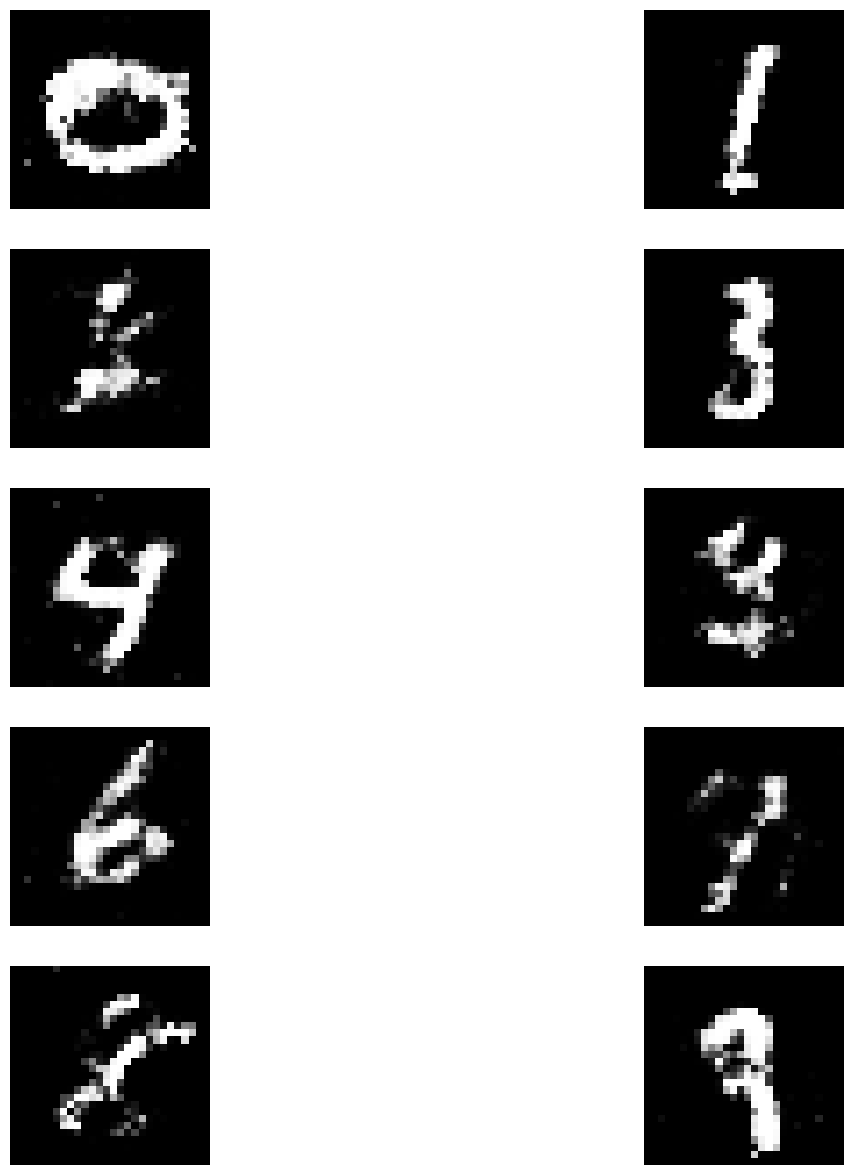

In [ ]:
import matplotlib.pyplot as plt

G.eval()
noises = torch.randn(10, noise_dim, device=device)
labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device=device, dtype=torch.long).view(-1, 1)
one_hot_label = torch.zeros(10, num_classes, device=device).scatter_(1, labels, 1)
generated_image = G(noises, one_hot_label).cpu().detach().numpy().squeeze()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()


In [ ]:
noise_dim = 500

In [ ]:
## TODO
num_classes = 10

class CondGenerator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(noise_dim + num_classes, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 1 * 28 * 28)

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(1024)

        self.lrelu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

    def generator(self, z, c):
        x = torch.cat([z, c], dim=1)
        x = self.lrelu(self.bn1(self.fc1(x)))
        x = self.lrelu(self.bn2(self.fc2(x)))
        x = self.lrelu(self.bn3(self.fc3(x)))
        x = self.tanh(self.fc4(x))
        x = x.view(-1, 1, 28, 28)

        return x

    def forward(self, z, c):
        z = self.generator(z, c)

        return z

G = CondGenerator().to(device)

In [ ]:
from torchinfo import summary

summary(G, [(BATCH_SIZE, noise_dim), (BATCH_SIZE, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
CondGenerator                            [256, 1, 28, 28]          --
├─Linear: 1-1                            [256, 256]                130,816
├─BatchNorm1d: 1-2                       [256, 256]                512
├─LeakyReLU: 1-3                         [256, 256]                --
├─Linear: 1-4                            [256, 512]                131,584
├─BatchNorm1d: 1-5                       [256, 512]                1,024
├─LeakyReLU: 1-6                         [256, 512]                --
├─Linear: 1-7                            [256, 1024]               525,312
├─BatchNorm1d: 1-8                       [256, 1024]               2,048
├─LeakyReLU: 1-9                         [256, 1024]               --
├─Linear: 1-10                           [256, 784]                803,600
├─Tanh: 1-11                             [256, 784]                --
Total params: 1,594,896
Trainable params: 1,594,896
Non-tr

In [ ]:
## TODO
class CondDiscriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1 * 28 * 28 + num_classes, 1024)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 1)

        self.lrelu = torch.nn.LeakyReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.3)

    def discriminator(self, z, c):
        x = torch.cat([z.view(-1, 1 * 28 * 28), c], dim=1)
        x = self.dropout(self.lrelu(self.fc1(x)))
        x = self.dropout(self.lrelu(self.fc2(x)))
        x = self.dropout(self.lrelu(self.fc3(x)))
        x = self.fc4(x)
        x = self.sigmoid(x)

        return x

    def forward(self, z, c):
        z = self.discriminator(z, c)

        return z


D = CondDiscriminator().to(device)

In [ ]:
summary(D, [(BATCH_SIZE, 1, 28, 28), (BATCH_SIZE, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
CondDiscriminator                        [256, 1]                  --
├─Linear: 1-1                            [256, 1024]               814,080
├─LeakyReLU: 1-2                         [256, 1024]               --
├─Dropout: 1-3                           [256, 1024]               --
├─Linear: 1-4                            [256, 512]                524,800
├─LeakyReLU: 1-5                         [256, 512]                --
├─Dropout: 1-6                           [256, 512]                --
├─Linear: 1-7                            [256, 256]                131,328
├─LeakyReLU: 1-8                         [256, 256]                --
├─Dropout: 1-9                           [256, 256]                --
├─Linear: 1-10                           [256, 1]                  257
├─Sigmoid: 1-11                          [256, 1]                  --
Total params: 1,470,465
Trainable params: 1,470,465
Non-trainable par

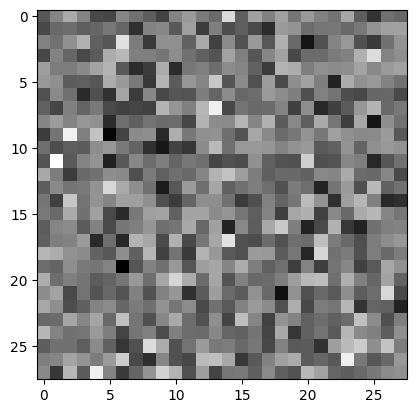

In [ ]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기
test_noise = torch.randn((1, noise_dim), device=device)
c = torch.zeros((1, num_classes), device=device)
G.eval()    # 생성자 G를 함수로 쓸 때는 eval로 설정해야 함.
fake_image_test = G(test_noise, c)

plt.imshow(fake_image_test.reshape(28, 28).cpu().detach().numpy(), cmap='gray')

In [ ]:
# Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.
D.eval()    # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
decision = D(fake_image_test, c)

print(decision)

tensor([[0.4928]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의
criterion = torch.nn.BCELoss()

# GAN 트레이닝에 쓰일 optimizer 정의
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

[0/50][0/235]	Loss_D: 1.3686	Loss_G: 0.7079	D(x): 0.5032	D(G(z)): 0.4941 / 0.4927
[0/50][50/235]	Loss_D: 0.2436	Loss_G: 4.6927	D(x): 0.9316	D(G(z)): 0.1407 / 0.0151
[0/50][100/235]	Loss_D: 0.2217	Loss_G: 16.5478	D(x): 0.9923	D(G(z)): 0.1577 / 0.1395
[0/50][150/235]	Loss_D: 0.1078	Loss_G: 31.1864	D(x): 0.9998	D(G(z)): 0.0968 / 0.0717
[0/50][200/235]	Loss_D: 0.0124	Loss_G: 34.0158	D(x): 0.9979	D(G(z)): 0.0095 / 0.0073


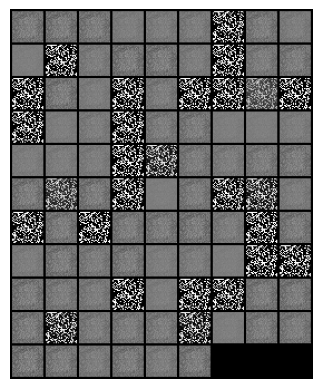

[1/50][0/235]	Loss_D: 0.0029	Loss_G: 31.5091	D(x): 0.9990	D(G(z)): 0.0018 / 0.0017
[1/50][50/235]	Loss_D: 0.0058	Loss_G: 35.0050	D(x): 0.9979	D(G(z)): 0.0032 / 0.0038
[1/50][100/235]	Loss_D: 0.0065	Loss_G: 32.3449	D(x): 0.9968	D(G(z)): 0.0009 / 0.0014
[1/50][150/235]	Loss_D: 0.0162	Loss_G: 30.7655	D(x): 0.9996	D(G(z)): 0.0138 / 0.0090
[1/50][200/235]	Loss_D: 0.0135	Loss_G: 29.4298	D(x): 0.9930	D(G(z)): 0.0033 / 0.0016
[2/50][0/235]	Loss_D: 0.0153	Loss_G: 31.0769	D(x): 0.9993	D(G(z)): 0.0118 / 0.0057
[2/50][50/235]	Loss_D: 0.0158	Loss_G: 29.7042	D(x): 0.9940	D(G(z)): 0.0072 / 0.0038
[2/50][100/235]	Loss_D: 0.0257	Loss_G: 27.1843	D(x): 0.9825	D(G(z)): 0.0040 / 0.0044
[2/50][150/235]	Loss_D: 0.0220	Loss_G: 28.0292	D(x): 0.9922	D(G(z)): 0.0115 / 0.0038
[2/50][200/235]	Loss_D: 0.0480	Loss_G: 27.0471	D(x): 0.9987	D(G(z)): 0.0297 / 0.0049
[3/50][0/235]	Loss_D: 0.0526	Loss_G: 25.9148	D(x): 0.9716	D(G(z)): 0.0084 / 0.0038
[3/50][50/235]	Loss_D: 0.0570	Loss_G: 25.2153	D(x): 0.9705	D(G(z)): 0.006

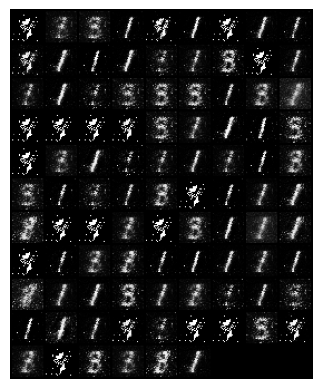

[11/50][0/235]	Loss_D: 0.0562	Loss_G: 5.6541	D(x): 0.9913	D(G(z)): 0.0337 / 0.0264
[11/50][50/235]	Loss_D: 0.0954	Loss_G: 7.2246	D(x): 0.9629	D(G(z)): 0.0049 / 0.0066
[11/50][100/235]	Loss_D: 0.1287	Loss_G: 5.9930	D(x): 0.9739	D(G(z)): 0.0326 / 0.0195
[11/50][150/235]	Loss_D: 0.0500	Loss_G: 7.0242	D(x): 0.9957	D(G(z)): 0.0367 / 0.0044
[11/50][200/235]	Loss_D: 0.0960	Loss_G: 4.8713	D(x): 0.9662	D(G(z)): 0.0207 / 0.0322
[12/50][0/235]	Loss_D: 0.0936	Loss_G: 6.1686	D(x): 0.9737	D(G(z)): 0.0270 / 0.0138
[12/50][50/235]	Loss_D: 0.1390	Loss_G: 6.1990	D(x): 0.9623	D(G(z)): 0.0198 / 0.0129
[12/50][100/235]	Loss_D: 0.1104	Loss_G: 6.3906	D(x): 0.9638	D(G(z)): 0.0183 / 0.0098
[12/50][150/235]	Loss_D: 0.1279	Loss_G: 4.9689	D(x): 0.9545	D(G(z)): 0.0223 / 0.0369
[12/50][200/235]	Loss_D: 0.1459	Loss_G: 5.1901	D(x): 0.9588	D(G(z)): 0.0417 / 0.0270
[13/50][0/235]	Loss_D: 0.1015	Loss_G: 5.9878	D(x): 0.9685	D(G(z)): 0.0213 / 0.0089
[13/50][50/235]	Loss_D: 0.0401	Loss_G: 6.3808	D(x): 0.9829	D(G(z)): 0.014

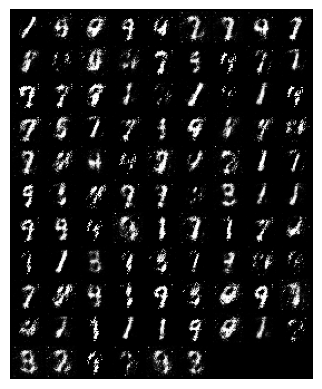

[21/50][0/235]	Loss_D: 0.3868	Loss_G: 3.5412	D(x): 0.9371	D(G(z)): 0.1708 / 0.0739
[21/50][50/235]	Loss_D: 0.3699	Loss_G: 3.7231	D(x): 0.8904	D(G(z)): 0.0813 / 0.0940
[21/50][100/235]	Loss_D: 0.3249	Loss_G: 3.4227	D(x): 0.9106	D(G(z)): 0.1152 / 0.1083
[21/50][150/235]	Loss_D: 0.3950	Loss_G: 4.0013	D(x): 0.8575	D(G(z)): 0.0561 / 0.0588
[21/50][200/235]	Loss_D: 0.3327	Loss_G: 3.0974	D(x): 0.9155	D(G(z)): 0.1230 / 0.1370
[22/50][0/235]	Loss_D: 0.3610	Loss_G: 3.7021	D(x): 0.9273	D(G(z)): 0.1530 / 0.0925
[22/50][50/235]	Loss_D: 0.4559	Loss_G: 3.7867	D(x): 0.8433	D(G(z)): 0.0631 / 0.0918
[22/50][100/235]	Loss_D: 0.3193	Loss_G: 4.2384	D(x): 0.8981	D(G(z)): 0.0761 / 0.0671
[22/50][150/235]	Loss_D: 0.3114	Loss_G: 3.7937	D(x): 0.9097	D(G(z)): 0.0993 / 0.0833
[22/50][200/235]	Loss_D: 0.2923	Loss_G: 4.3860	D(x): 0.9177	D(G(z)): 0.0737 / 0.0701
[23/50][0/235]	Loss_D: 0.2699	Loss_G: 5.2212	D(x): 0.9085	D(G(z)): 0.0670 / 0.0373
[23/50][50/235]	Loss_D: 0.3039	Loss_G: 3.6525	D(x): 0.9124	D(G(z)): 0.092

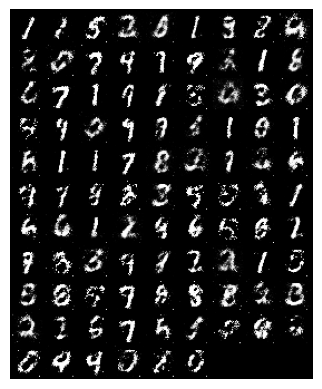

[31/50][0/235]	Loss_D: 0.4932	Loss_G: 4.0667	D(x): 0.8681	D(G(z)): 0.1763 / 0.0709
[31/50][50/235]	Loss_D: 0.5445	Loss_G: 3.1066	D(x): 0.8306	D(G(z)): 0.1627 / 0.1614
[31/50][100/235]	Loss_D: 0.5598	Loss_G: 2.2729	D(x): 0.8624	D(G(z)): 0.2234 / 0.2196
[31/50][150/235]	Loss_D: 0.5038	Loss_G: 2.8403	D(x): 0.8135	D(G(z)): 0.1434 / 0.1335
[31/50][200/235]	Loss_D: 0.4299	Loss_G: 3.0118	D(x): 0.8408	D(G(z)): 0.1080 / 0.1541
[32/50][0/235]	Loss_D: 0.5574	Loss_G: 2.3445	D(x): 0.8370	D(G(z)): 0.1868 / 0.2160
[32/50][50/235]	Loss_D: 0.7169	Loss_G: 2.8857	D(x): 0.7500	D(G(z)): 0.1498 / 0.1260
[32/50][100/235]	Loss_D: 0.7193	Loss_G: 2.4152	D(x): 0.7589	D(G(z)): 0.1917 / 0.1923
[32/50][150/235]	Loss_D: 0.5746	Loss_G: 2.4101	D(x): 0.7936	D(G(z)): 0.1702 / 0.2087
[32/50][200/235]	Loss_D: 0.5756	Loss_G: 3.0113	D(x): 0.7917	D(G(z)): 0.1567 / 0.1382
[33/50][0/235]	Loss_D: 0.5945	Loss_G: 2.7443	D(x): 0.7844	D(G(z)): 0.1499 / 0.1664
[33/50][50/235]	Loss_D: 0.5420	Loss_G: 2.8190	D(x): 0.7819	D(G(z)): 0.111

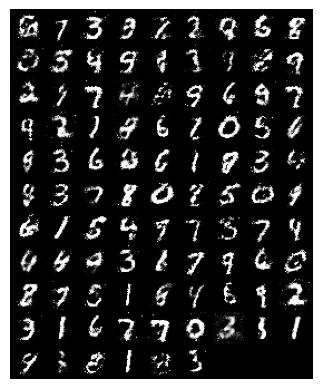

[41/50][0/235]	Loss_D: 0.7645	Loss_G: 2.0836	D(x): 0.7489	D(G(z)): 0.2429 / 0.2117
[41/50][50/235]	Loss_D: 0.7253	Loss_G: 2.2021	D(x): 0.7116	D(G(z)): 0.1665 / 0.1806
[41/50][100/235]	Loss_D: 0.7925	Loss_G: 1.9971	D(x): 0.7428	D(G(z)): 0.2434 / 0.2498
[41/50][150/235]	Loss_D: 0.7407	Loss_G: 2.0431	D(x): 0.7780	D(G(z)): 0.2646 / 0.2339
[41/50][200/235]	Loss_D: 0.8878	Loss_G: 2.1242	D(x): 0.7070	D(G(z)): 0.2404 / 0.2074
[42/50][0/235]	Loss_D: 0.7031	Loss_G: 2.1154	D(x): 0.7368	D(G(z)): 0.1968 / 0.2252
[42/50][50/235]	Loss_D: 0.7514	Loss_G: 2.0118	D(x): 0.7426	D(G(z)): 0.2040 / 0.2365
[42/50][100/235]	Loss_D: 0.6687	Loss_G: 2.0610	D(x): 0.7881	D(G(z)): 0.2476 / 0.2017
[42/50][150/235]	Loss_D: 0.7348	Loss_G: 2.0205	D(x): 0.7441	D(G(z)): 0.2227 / 0.2215
[42/50][200/235]	Loss_D: 0.8934	Loss_G: 1.7072	D(x): 0.7374	D(G(z)): 0.2929 / 0.2738
[43/50][0/235]	Loss_D: 0.8751	Loss_G: 1.9103	D(x): 0.6702	D(G(z)): 0.2281 / 0.2253
[43/50][50/235]	Loss_D: 0.7896	Loss_G: 1.6908	D(x): 0.7399	D(G(z)): 0.257

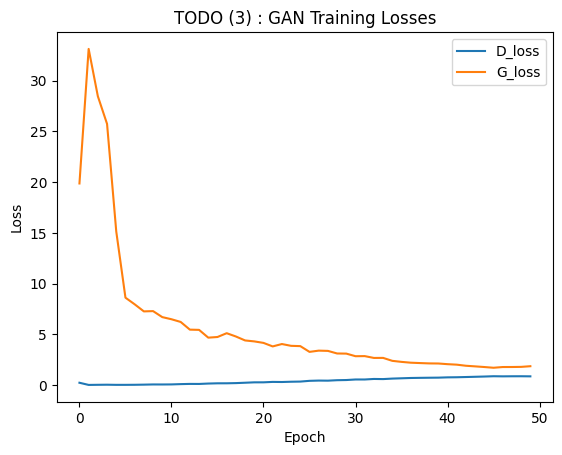

Training Finished!


In [ ]:
import math

G.train()
D.train()

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(EPOCHS):
  D_losses = []
  G_losses = []

  for i, (images, labels) in enumerate(train_loader):
    #############################
    # 1) Update discriminator D #
    #############################
    D.zero_grad()

    images_real = images.to(device)
    labels = labels.to(device)
    one_hot_label = torch.zeros((labels.size(0), num_classes), device=device)
    one_hot_label.scatter_(1, labels.unsqueeze(1), 1)  # one-hot 벡터로 변환
    y_pred_real = D(images_real, one_hot_label).view(-1)    # 진짜 MNIST 데이터를 본 Discriminator의 판별값
    label = torch.full((images_real.size(0),), 1., dtype=torch.float, device=device)    # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network D가 진짜 데이터를 진짜로 판별했는지를 평가
    D_real_loss = criterion(y_pred_real, label)
    D_real_loss.backward()

    D_x = y_pred_real.mean().item()

    # 가짜 데이터 생성
    noises = torch.randn([images_real.size(0), noise_dim], device=device)   # Generator에 입력으로 줄 noise
    images_fake = G(noises, one_hot_label)           # Generator는 noise로부터 가짜 데이터를 생성

    y_pred_fake = D(images_fake.detach(), one_hot_label).view(-1)      # Generator가 만든 가짜 데이터를 본 Discriminator의 판별값
    label.fill_(0.)        # 가짜 데이터에 대한 label 값은 0

    # Network D가 가짜 데이터를 가짜로 판별했는지를 평가
    D_fake_loss = criterion(y_pred_fake, label)
    D_fake_loss.backward()

    D_G_z1 = y_pred_fake.mean().item()

    D_loss = D_real_loss + D_fake_loss

    # Update D
    D_optimizer.step()

    #############################
    # 2) Update discriminator G #
    #############################
    G.zero_grad()

    y_pred_fake = D(images_fake, one_hot_label).view(-1)
    label.fill_(1.)       # 진짜 MNIST 데이터에 대한 label 값은 1

    # Network G가 생선한 가짜 데이터를 D가 진짜라고 판별했는지를 평가한다.
    G_loss = criterion(y_pred_fake, label)
    G_loss.backward()

    D_G_z2 = y_pred_fake.mean().item()

    # Update G
    G_optimizer.step()

    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(train_loader),
                     D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))

    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())

    # 일정 시점에서 (ex. epoch % 10 == 0) network G가 생성한 가짜 데이터를 가시화하여 변화를 확인한다.

  train_hist['D_losses'].append(torch.mean(torch.Tensor(D_losses)))
  train_hist['G_losses'].append(torch.mean(torch.Tensor(G_losses)))
  if epoch % 10 == 0:
        with torch.no_grad():
            fixed_images_fake = G(noises, one_hot_label)  # 고정된 noise 값으로부터 가짜 데이터를 생성
            fixed_images_fake = fixed_images_fake.view(-1, 1, 28, 28)  # 이미지 형태로 변환

            # 가시화를 위해 이미지를 그리드 형태로 배치하여 시각화
            grid = torchvision.utils.make_grid(fixed_images_fake, nrow=int(math.sqrt(images_real.size(0))), normalize=True)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

plt.plot(train_hist['D_losses'], label='D_loss')
plt.plot(train_hist['G_losses'], label='G_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TODO (3) : GAN Training Losses')
plt.show()
print('Training Finished!')

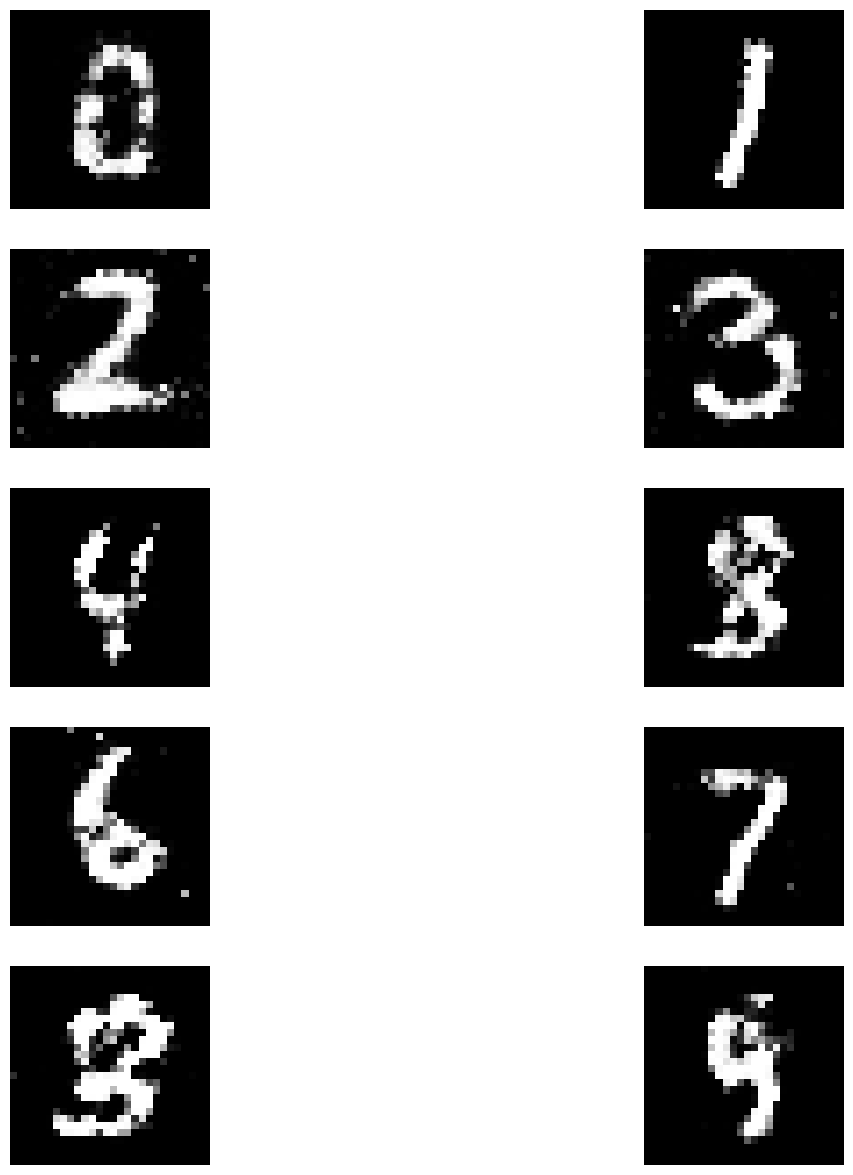

In [ ]:
import matplotlib.pyplot as plt

G.eval()
noises = torch.randn(10, noise_dim, device=device)
labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device=device, dtype=torch.long).view(-1, 1)
one_hot_label = torch.zeros(10, num_classes, device=device).scatter_(1, labels, 1)
generated_image = G(noises, one_hot_label).cpu().detach().numpy().squeeze()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[3,0].imshow(generated_image[6], cmap='gray')
axes[3,1].imshow(generated_image[7], cmap='gray')
axes[4,0].imshow(generated_image[8], cmap='gray')
axes[4,1].imshow(generated_image[9], cmap='gray')

plt.show()
